In [54]:
from IPython.display import Image
import numpy as np
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#**NLP Project**
##Project made by:
-  Nicolas Laine
-  Paul Rouxel
-  Quentin Richard
-  Barnabé Naturel
-  Victor Jouet
-  Antoine Lopez

**ING5 grp2 Data&IA**


# Sport Orientation with NLP & Skill Analysis

This project aims to recommend the best sports for a user based on their answers to a form.

The form collects:
- Open-ended questions
- Likert-scale questions
- Numeric questions
- MCQs or checkboxes

We combine semantic analysis (for open questions) and numeric analysis (for structured answers)
The main idea of our code is to produce a **skill vector**(that describe the user). Then we compare it to **sports skill vectors**(pre-made and saved in a .json file) to suggest the best sports.


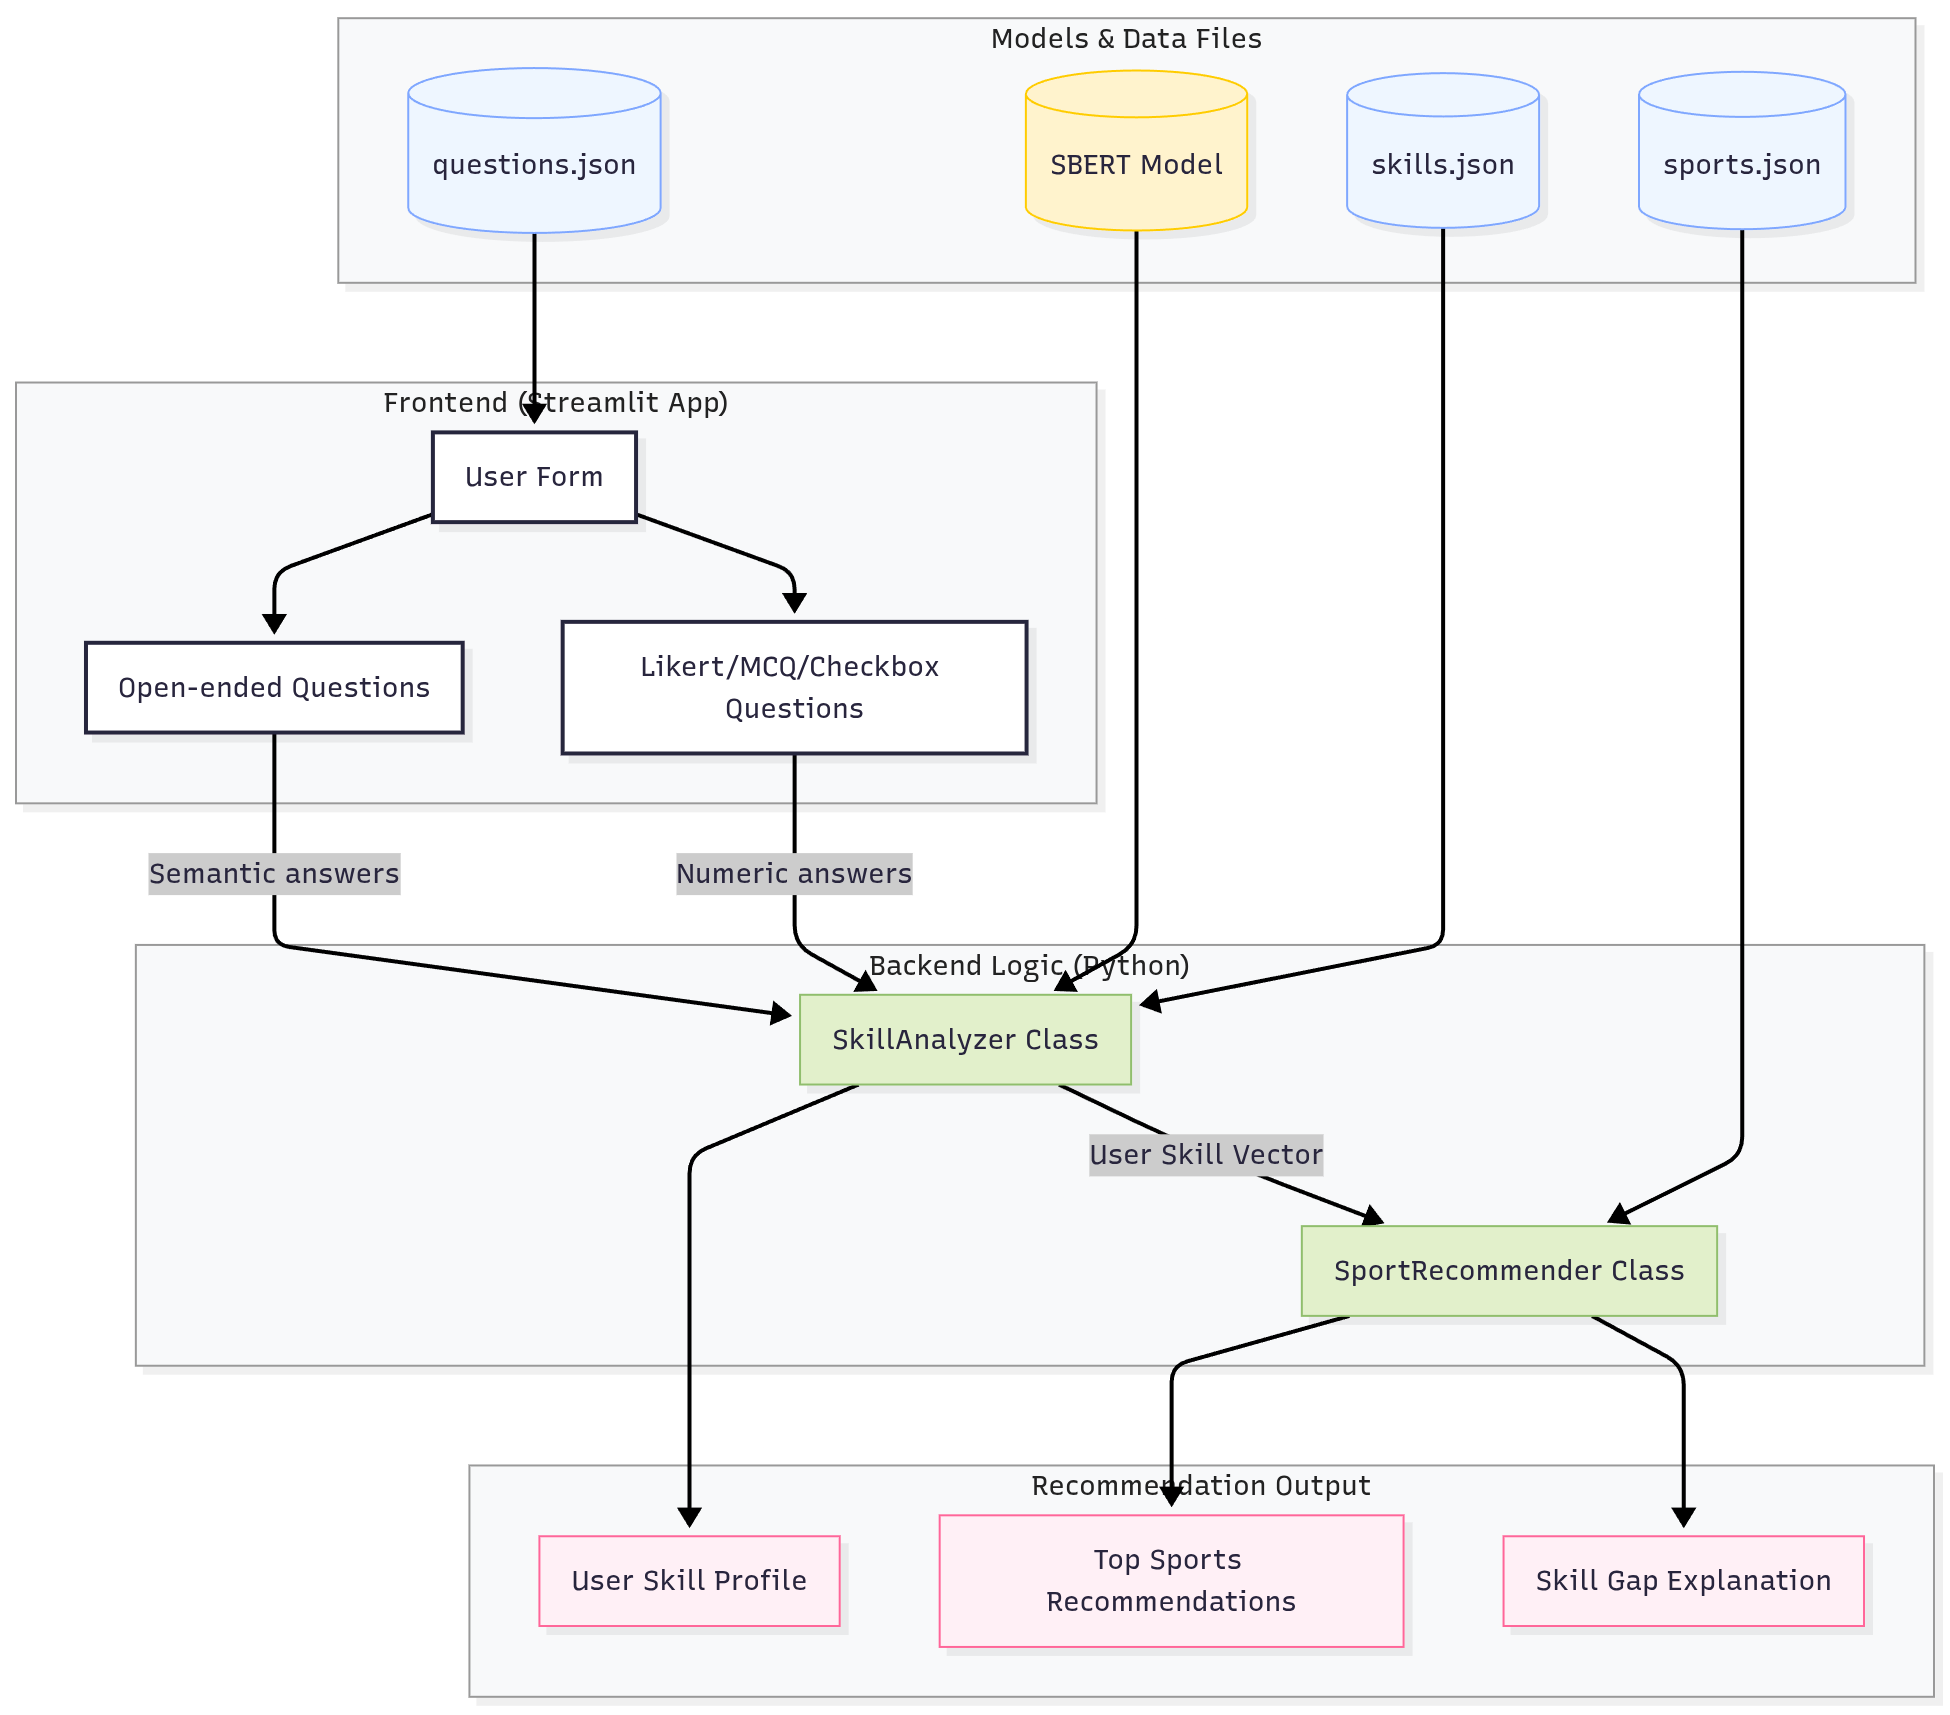

In [55]:
display(Image(filename='NLP_project_architecture.png', width=1080))

# Semantic Analystics





###The Goal
The system builds a user skill vector. It's the numerical representation of how strong the user is in each skill *(e.g., strength, agility, teamwork, etc.)*.
```
user_vector = [s1, s2, ...,sn]
```

Each component *si* represents the user’s estimated level in skill i, derived from both, semantic and numeric analysis.
The vectorization process homogenizes multi-format input data, converting diverse user inputs into a single, comparable numeric representation.


Similarly, each sport is also represented by a skill requirement vector
```
sport_vector = [v1, v2, ...,vn]
```
That indicates how important skill i is for that sport.

###How the user_vector is build
It’s the combination of semantic Analysis from the open-ended answers and numeric analysis from the other format of answer.

####Semantic analysis
The user writes something like:
-  “I like endurance sports and enjoy working in a team.”

Each sentence is turned into an embedding (a numerical vector) using SBERT.Then, we compare this sentence vector with each skill embedding (computed once from skill.json). The higher the cosine similarity is the more this sentence relates to that skill.

In [56]:
skills = ["strength", "endurance", "teamwork", "precision"]

model = SentenceTransformer("all-MiniLM-L6-v2")

sports = {
    "football": {"strength": 0.8, "endurance": 0.9, "teamwork": 1.0, "precision": 0.6},
    "tennis": {"strength": 0.6, "endurance": 0.7, "teamwork": 0.4, "precision": 0.9},
}

answer = "I like working in teams and running long distances."

# Embeddings
# Encode the skill names into numerical vectors
skill_embeddings = model.encode(skills, normalize_embeddings=True)
# Encode the user's answer into a numerical vector
answer_emb = model.encode(answer, normalize_embeddings=True)

# Calculate the cosine similarity between the answer embedding and each skill embedding
# Cosine similarity measures the angle between two vectors, indicating how similar they are in direction.
# A higher cosine similarity means the vectors are more similar.
similarities = util.cos_sim(answer_emb, skill_embeddings)[0].cpu().numpy()

# Build normalized user vector
semantic_score = {skill: float(sim)*10 for skill, sim in zip(skills, similarities)}
print(semantic_score)

{'strength': 2.3112478852272034, 'endurance': 3.3960068225860596, 'teamwork': 3.357667922973633, 'precision': 0.3884092718362808}


####Numeric analysis
The numeric anaysis got applicated on the MCQ, Likert, Checkboxes question types.
For Likert and checkbox questions, you already know which skill each one measures.
```
{
  "q3": {
    "text": "How comfortable are you working in a team?",
    "type": "likert",
    "skill": "teamwork",
    "scale": {"min": 1, "max": 10, "default": 5}
  }
}
```
Then, the analyzer collects all numeric answers into a similar vector:


In [57]:
question = "How comfortable are you working in a team?"

# User answered a question about endurance on a scale from 1 to 10
user_answer = {"teamwork": 8}

# We create a numeric skill vector (normalized or not)
numeric_vector = {skill: user_answer.get(skill, 0.0) for skill in skills}


print(numeric_vector)


{'strength': 0.0, 'endurance': 0.0, 'teamwork': 8, 'precision': 0.0}


####Combining the two
Once both semantic and numeric skill profiles are computed, you merge them:<br>
`final_scores[skill] = (0.6 * semantic_score + 0.4 * numeric_score)`


So the final user skill vector reflects both:
- what the user says (semantic meaning), and
- what the user rates themselves as (numeric).

In [58]:
final_scores = {}
for skill in skills:
    final_scores[skill] = (0.9 * semantic_score.get(skill, 0.0) + 0.1 * numeric_vector.get(skill, 0.0))
print(final_scores)

{'strength': 2.080123096704483, 'endurance': 3.0564061403274536, 'teamwork': 3.8219011306762694, 'precision': 0.34956834465265274}


####Normalization
To make all scores comparable across users:
`final_profile = SkillAnalyzer.normalize_by_l2(final_scores)`<br>
This scales the vector to unit length:<br>
X_norm = X / |X|^2<br>

It ensures that absolute scale doesn’t matter and only relative strengths between skills matters.

In [59]:
def normalize_by_l2(vec):
    norm = np.sqrt(sum(v**2 for v in vec.values()))
    return {k: v / norm for k, v in vec.items()} if norm else vec

user_vector = normalize_by_l2(final_scores)
print(user_vector)

{'strength': np.float64(0.39034424661596245), 'endurance': np.float64(0.5735480530400623), 'teamwork': np.float64(0.7171965543087603), 'precision': np.float64(0.06559803713078725)}


###Sport Recommender

The **SportRecommender** compares the user's skill profile to every sport's skill profile using cosine similarity.<br>
Each sport is represented as a vector of skill coefficients.<br>
The closer the cosine similarity is to 1, the more the two profiles are aligned.<br>
The system then returns the top sports with the highest similarity scores.

In [60]:
def cosine_similarity(u, v):
    u_vec = np.array(list(u.values()))
    v_vec = np.array(list(v.values()))
    return np.dot(u_vec, v_vec) / (np.linalg.norm(u_vec) * np.linalg.norm(v_vec))

for sport, vec in sports.items():
    score = cosine_similarity(user_vector, vec)
    print(f"{sport}: {score:.3f}")

football: 0.946
tennis: 0.728


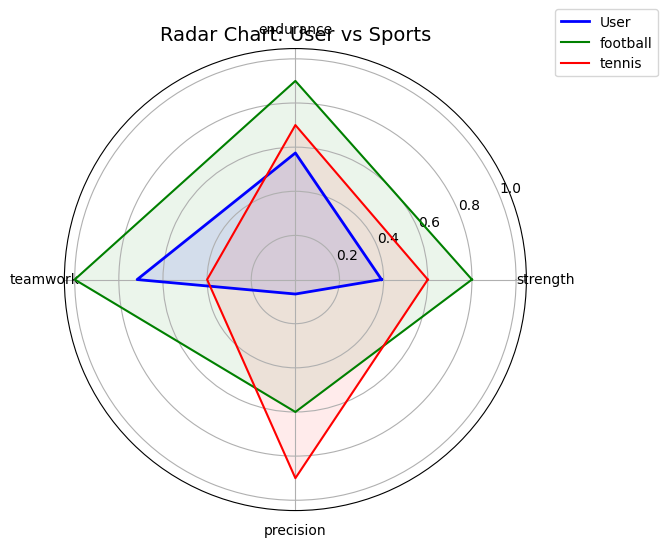

In [61]:
angles = np.linspace(0, 2 * np.pi, len(skills), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

vals = [user_vector[s] for s in skills]
vals += vals[:1]
ax.plot(angles, vals, color="blue", linewidth=2, label="User")
ax.fill(angles, vals, color="blue", alpha=0.1)

colors = ["green", "red", "orange", "purple"]
for (name, vec), c in zip(sports.items(), colors):
    v = [vec[s] for s in skills]
    v += v[:1]
    ax.plot(angles, v, color=c, linewidth=1.5, label=name)
    ax.fill(angles, v, color=c, alpha=0.08)

ax.set_thetagrids(np.degrees(angles[:-1]), skills)
ax.set_title("Radar Chart: User vs Sports", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()

#Sources:
Architecture schema made on mermaids<br>
Model : https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2<br>